# Compute label distances in latent space

Computing distances between labels in the latent space. Use the closed form KL divergence by estimating GRVs for each label.

### Imports

In [1]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [20]:
import os
import itertools

import numpy as np
from sklearn.manifold import TSNE
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp
from scipy.stats import ttest_ind, wasserstein_distance, ks_2samp
import umap
from scipy.stats import norm
from sklearn.manifold import TSNE

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

In [5]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.hypothesis_testing.variance as vr
import scvi_extensions.dataset.label_data_loader as ldl

### Load the model

In [6]:
kogene_model = torch.load('/Users/mincheolkim/Documents/vaec_model_vargenes_kogene.model', map_location=lambda storage, loc: storage)

### Create the dataset with guides as labels

In [7]:
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1_default.norm.meta.txt'

In [8]:
imp.reload(cs)
# Load the dataset
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    new_n_genes=1000,
    use_donors=True,
    use_labels='gene',
    testing_labels='gene',
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 283634
Number of cells kept after removing all zero cells: 283634
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 1000 genes


### Create a dataloader

In [9]:
data_loader = sdl.SupervisedTrainTestDataLoaders(gene_dataset, num_samples=50000)

### Sampling latent space

In [14]:
def get_cropseq_latent(vae, data_loader):
    latent = []
    batch_indices = []
    labels = []
    for tensors in data_loader:
        sample_batch, local_l_mean, local_l_var, batch_index, label, testing_label = tensors
        latent += [vae.sample_from_posterior_z(sample_batch, y=label)]
        batch_indices += [batch_index]
        labels += [testing_label]
    return np.array(torch.cat(latent)), np.array(torch.cat(batch_indices)), np.array(torch.cat(labels)).ravel()

In [15]:
latent, batch_indices, labels = get_cropseq_latent(kogene_model, data_loader['all'])

In [18]:
variables = {}
for label in np.unique(labels):
    label_batch = latent[labels == label, :]
    variables[label] = MultivariateNormal(
        loc=torch.tensor(label_batch.mean(axis=0)),
        covariance_matrix=torch.tensor(np.diag(label_batch.var(axis=0))))

In [25]:
distance_matrix = np.zeros((141, 141))
for label_1, label_2 in itertools.permutations(np.unique(labels), 2):
    distance_matrix[label_1][label_2] = kl_divergence(variables[label_1], variables[label_2])

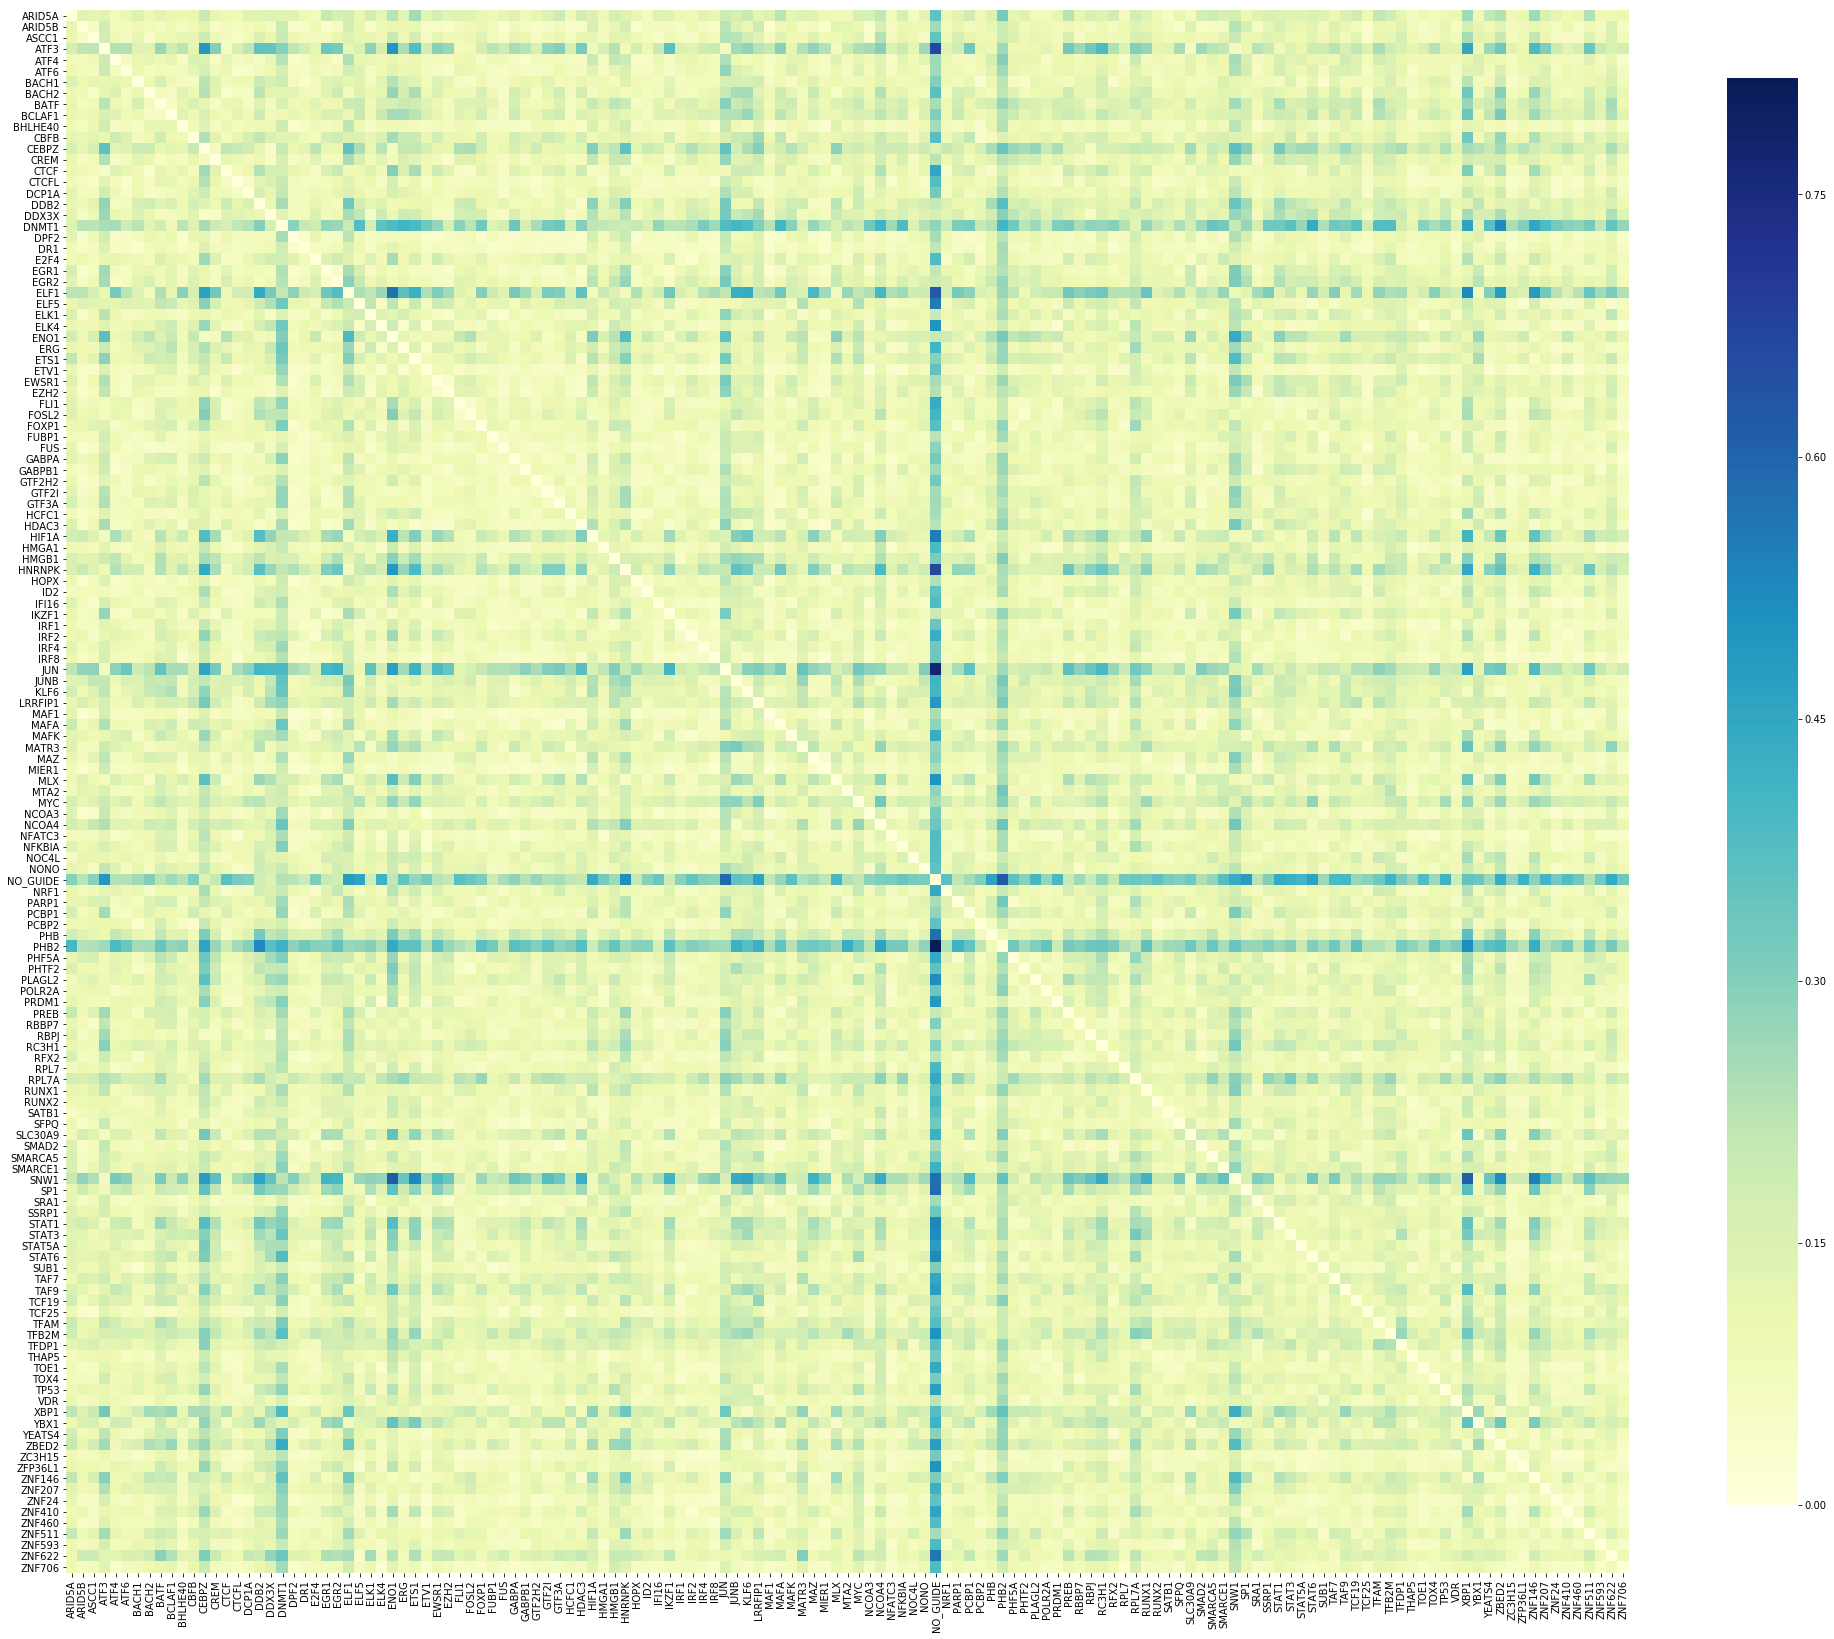

In [58]:
plt.figure(figsize=(35, 35))
sns.heatmap(distance_matrix, square=True, cmap="YlGnBu",cbar_kws={"shrink": .75});
yloc, _ = plt.yticks();
xloc, _ = plt.xticks();
plt.yticks(yloc, gene_dataset.ko_gene_lookup);
plt.xticks(xloc, gene_dataset.ko_gene_lookup, rotation=90);
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/labmeeting/gene_kl_divergence.png', bbox_inches='tight')

In [32]:
gene_dataset.ko_gene_lookup[78]

'NO_GUIDE'

In [63]:
deviations_from_noguide = pd.DataFrame(
    list(zip(gene_dataset.ko_gene_lookup, distance_matrix[78, :])), 
    columns=['gene', 'kl_divergence'])\
    .sort_values('kl_divergence', ascending=False)

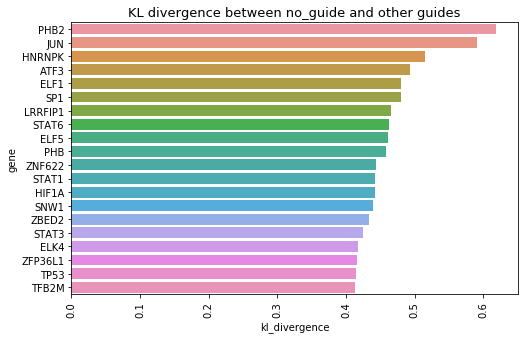

In [96]:
plt.figure(figsize=(8, 5))
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
sns.barplot(y='gene', x='kl_divergence', data=deviations_from_noguide.head(20))
plt.tick_params(axis='x', rotation=90);
plt.title('KL divergence between no_guide and other guides', fontsize=13);
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/labmeeting/kl_barplot.png', bbox_inches='tight')

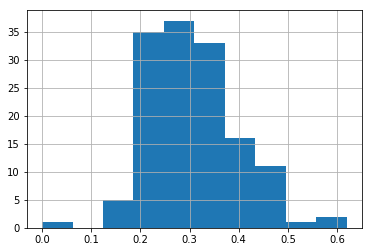

In [68]:
deviations_from_noguide.kl_divergence.hist()

In [60]:
deviations_from_noguide

array([0.29487228, 0.2239027 , 0.2918849 , 0.49397087, 0.23144579,
       0.2301178 , 0.26286364, 0.30293655, 0.22188234, 0.25848579,
       0.22790718, 0.30161858, 0.14806843, 0.20554399, 0.36234617,
       0.31737232, 0.3040657 , 0.17914391, 0.14938545, 0.23500013,
       0.22449112, 0.18911886, 0.30672359, 0.19537878, 0.17438984,
       0.48063278, 0.46181011, 0.17549562, 0.41720819, 0.21131325,
       0.35222435, 0.27696705, 0.31409454, 0.22202301, 0.20955992,
       0.36911297, 0.33589792, 0.31138325, 0.19114113, 0.2472043 ,
       0.28620386, 0.23541498, 0.27475023, 0.23574495, 0.24400187,
       0.21463823, 0.2060132 , 0.44229841, 0.31932449, 0.26429462,
       0.51497507, 0.20721912, 0.29544449, 0.34009457, 0.18950224,
       0.29122829, 0.35294771, 0.29757833, 0.28738213, 0.59116125,
       0.35966635, 0.33620739, 0.46547127, 0.21356058, 0.27418518,
       0.36602592, 0.23339748, 0.25724554, 0.2142849 , 0.39980602,
       0.23594332, 0.21189213, 0.28733635, 0.30663681, 0.31568

In [ ]:
gene_dataset.ko_gene_lookup[78]

In [35]:
gene_dataset.ko_gene_lookup[3]

'ATF3'

In [34]:
gene_dataset.ko_gene_lookup[59]

'JUN'

In [33]:
gene_dataset.ko_gene_lookup[84]

'PHB2'